<a href="https://colab.research.google.com/github/hyeonu96/first-repository/blob/main/%5BEX_09%5D%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%9D%B8%EB%AC%BC_%EB%AA%A8%EB%93%9C_%EB%AC%B8%EC%A0%9C%EC%A0%90_%EC%B0%BE%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 인물 모드 문제점 찾기

In [34]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import os

from matplotlib import pyplot as plt
import tensorflow as tf


In [14]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [16]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/content/drive/MyDrive/picture/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /root/content/drive/MyDrive/picture/models
model loaded successfully!


#1

(735, 550, 3)


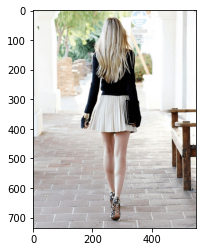

(0.0, 256.0)

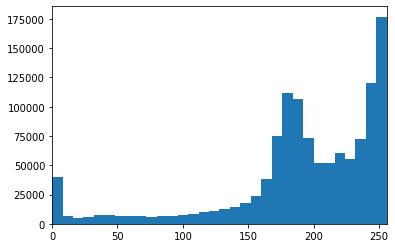

In [19]:
img_path = '/content/drive/MyDrive/picture/models/다운로드.jfif'   
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [20]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(735, 550, 3) (513, 383, 3) 15


In [21]:
# DeepLab의 PASCAL VOC 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

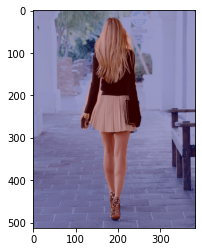

In [22]:
# 세그멘테이션

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

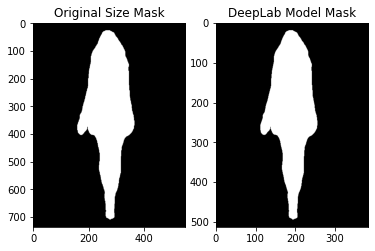

In [23]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

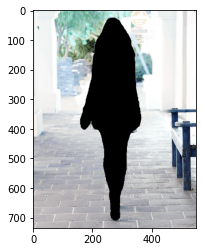

In [24]:
# 세그멘테이션 마스크를 이용하여 배경만 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)       #이미지 반전! 배경은 255, 사람이 0
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)     #배경만 있는 연산 get

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

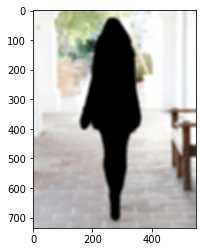

In [25]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

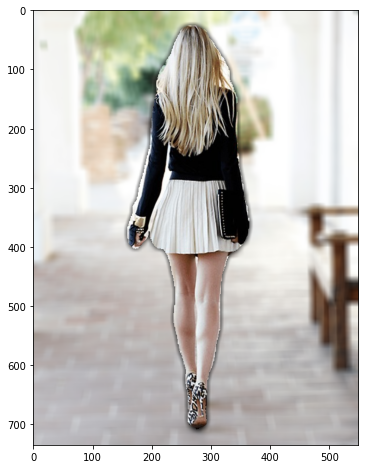

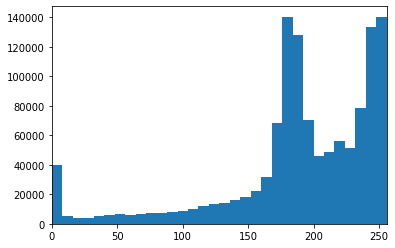

In [26]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

인물과 배경의 선이 확실하게 눈에 보여서 아쉽다.


#2

In [35]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (1).jfif' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(774, 620, 3)


In [36]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(774, 620, 3) (513, 410, 3) 15


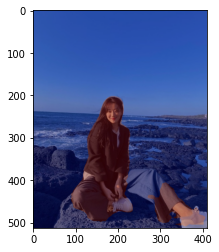

In [37]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

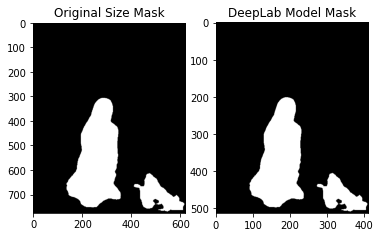

In [38]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

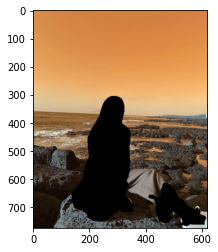

In [39]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

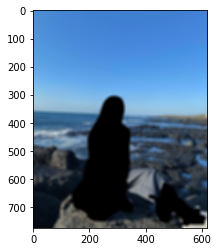

In [41]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

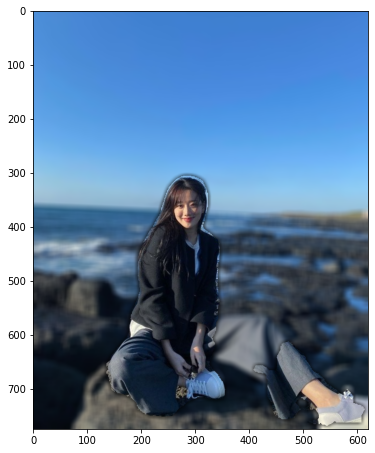

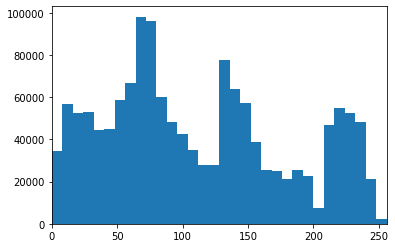

In [42]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

배경과 하의 색이 비슷하여 다리를 배경으로 인식하여 다리가 나눠진 현상을 볼 수 있었다.

#3


In [43]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (2).jfif' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(512, 512, 3)


In [44]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(512, 512, 3) (513, 513, 3) 15


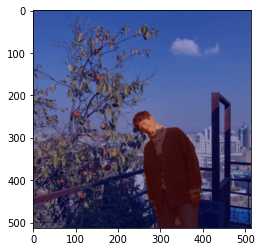

In [45]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

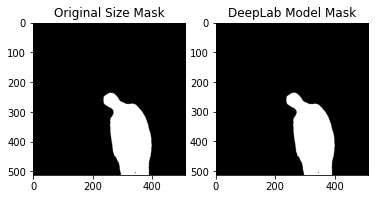

In [46]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

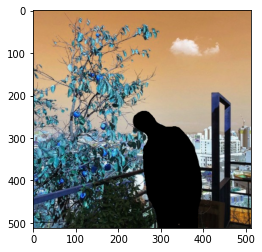

In [47]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

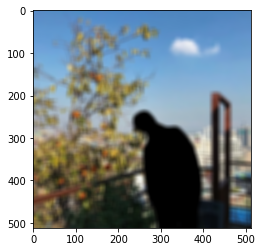

In [48]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

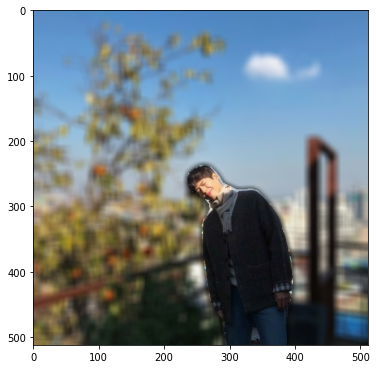

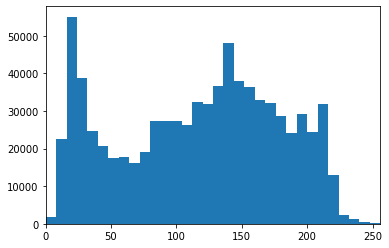

In [49]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me3_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

경계도 잘 나뉘어졌고 인물도 확실히 잘잡았음.

##고양이 사진모드

In [50]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (3).jfif'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(818, 620, 3)


In [51]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(818, 620, 3) (513, 388, 3) 8


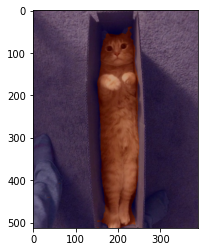

In [52]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

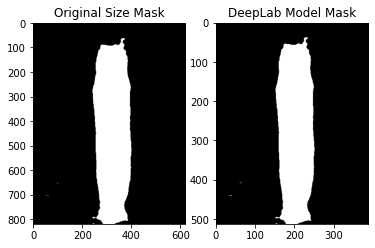

In [53]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

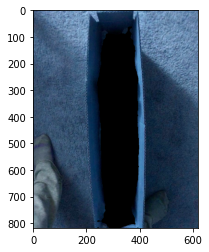

In [54]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

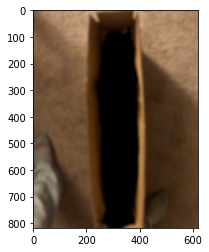

In [55]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

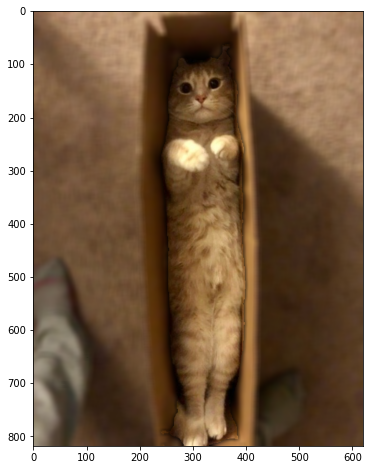

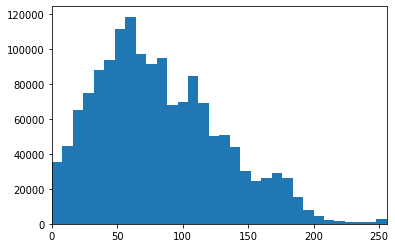

In [56]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

박스와 고양이 색이 비슷하여 경계가 완전히 잘 나뉘어지지 않았음.
고양이가 너무 귀여움

In [57]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (4).jfif'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(400, 400, 3)


In [58]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(400, 400, 3) (513, 513, 3) 8


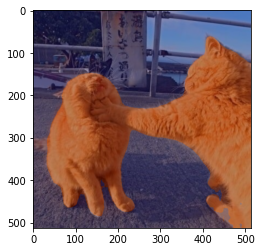

In [59]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

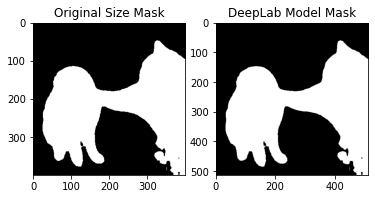

In [60]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

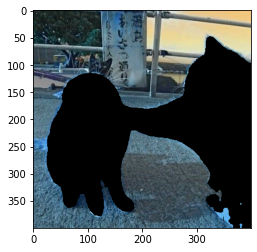

In [61]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

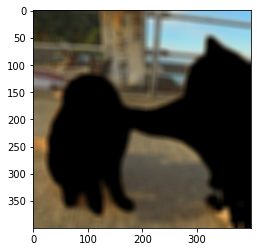

In [62]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

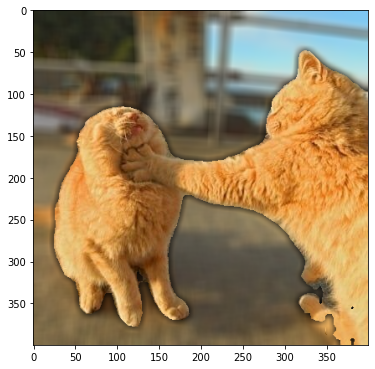

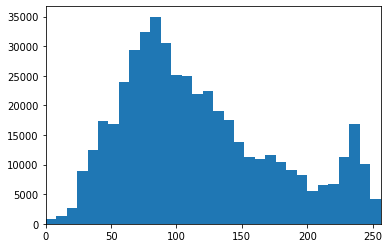

In [63]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat2_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

고양이 2마리로 실험을 해보았다.
고양이 2마리 모두 인식이 되는 모습.
오른쪽 고양이 하체쪽은 경계가 확실하게 구분되지 않았다.


##크로마키 사진 모드

In [64]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (2).jfif'  
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (335, 512)) # 풍경 사이즈와 맞게 resize
print (img_orig.shape)

(512, 335, 3)


In [65]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(512, 335, 3) (513, 335, 3) 15


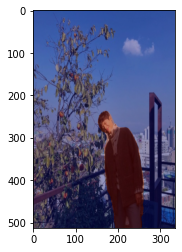

In [66]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

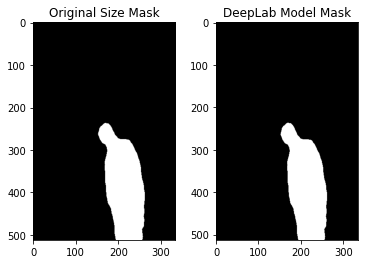

In [67]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

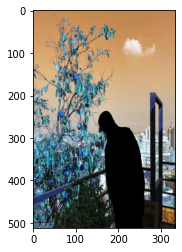

In [70]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

In [88]:
bg_path = '/content/drive/MyDrive/picture/models/피사의사탑배경.jfif'  
bg_orig = cv2.imread(bg_path)
img_concat = np.where(img_bg==0, img_bg, bg_orig)
print (bg_orig.shape)
plt.imshow(img_concat)
plt.show()

ValueError: ignored

In [72]:
cromakey = np.where(img_mask_color==255, img_orig, img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(cromakey, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: ignored

#2.2

In [74]:
img_path = '/content/drive/MyDrive/picture/models/다운로드 (4).jfif' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(400, 400, 3)


In [75]:
bg_path = '/content/drive/MyDrive/picture/models/에펠탑배경.jfif'  
bg_orig = cv2.imread(bg_path)
print (bg_orig.shape)

(827, 620, 3)


In [76]:
img_orig = cv2.resize(img_orig, (512, 410)) # 풍경 사이즈와 맞게 resize

In [77]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(410, 512, 3) (410, 513, 3) 8


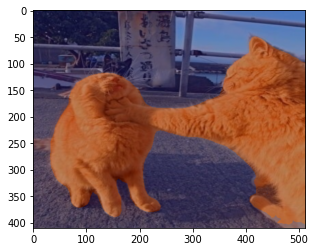

In [78]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

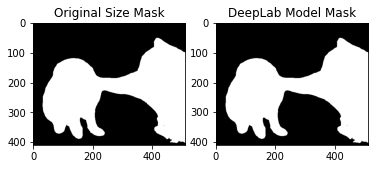

In [79]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

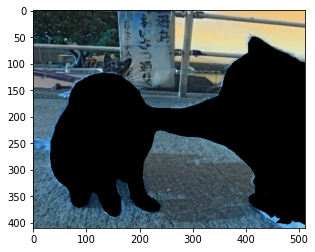

In [80]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

In [87]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

ValueError: ignored

루브릭

1. 인물모드 사진을 성공적으로 제작하였다.

인물과 고양이 사진모드는 성공적이었지만 크로마키 모드에서 다소 이슈가 있었다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

바로바로 지적해 보았다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

이부분이 굉장히 어려웠다.

- 부가 설명을 한다면,
인물이나 고양이 사진 등 배경과 객체의 색이 비슷하면 경계가 명확하게 구분이 되지 않는다는 점이 문제다. 여기서 RGB를 더 많이 추가한다면 색을 확실히 구분할 수 있고 경계도 확실해질수 있다.